In [57]:
import numpy as np
import seaborn as sns
import pandas as pd
import glob
import os
from collections import defaultdict
from scipy import stats
import pickle
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

In [75]:
files = glob.glob("../data/adaptive_trajectories/*.csv")

trajectories_by_temp = defaultdict(lambda: [])
for fn in files:
    basename = os.path.basename(fn).split('.')[0].split("_")
    T, i = int(basename[1]), int(basename[2])
    
    trajectories_by_temp[T].append(pd.read_csv(fn))

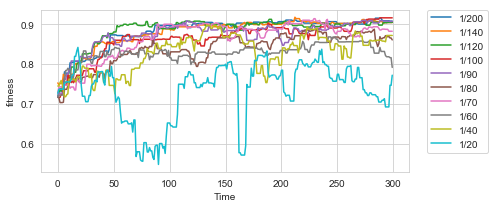

In [72]:
# get fitness
pp = PdfPages("../figures/fig4c.pdf")
plt.figure(figsize=[7,3])
for T in sorted(list(trajectories_by_temp.keys()))[::-1]:
    sns.lineplot(x=range(300), y=trajectories_by_temp[T][0]["fitness"], label="1/{}".format(T))
plt.xlabel("Time")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
pp.savefig()
pp.close()

In [11]:
seq = ['C', 'P', 'I', 'E', 'D', 'F', 'L', 'M', 'A', 'M', 'D', 'M', 'G', 'P', 'W', 'I', 'A', 'S', 'F', 'R']
position_to_contacts = {
    1: [3, 8, 9],
    2: [4, 8],
    3: [5, 6, 7, 1],
    4: [6, 2],
    5: [3, 20, 19],
    6: [4, 20, 19, 8, 16],
    7: [3, 19, 16, 15, 9, 10],
    8: [2, 3, 6, 10],
    9: [1, 7, 11],
    10: [8, 16, 15, 12],
    11: [9, 15],
    12: [10, 15, 14],
    13: [15],
    14: [17, 16, 12],
    15: [7, 17, 10, 11, 12, 13],
    16: [6, 19, 18, 7, 10, 14],
    17: [19, 14, 15],
    18: [16, 20],
    19: [5, 6, 7, 16, 17],
    20: [5, 6, 18]
}
# zero-indexed
for i in range(20):
    position_to_contacts[i] = [x-1 for x in position_to_contacts[i+1]]
position_to_contacts

{1: [3, 7],
 2: [4, 5, 6, 0],
 3: [5, 1],
 4: [2, 19, 18],
 5: [3, 19, 18, 7, 15],
 6: [2, 18, 15, 14, 8, 9],
 7: [1, 2, 5, 9],
 8: [0, 6, 10],
 9: [7, 15, 14, 11],
 10: [8, 14],
 11: [9, 14, 13],
 12: [14],
 13: [16, 15, 11],
 14: [6, 16, 9, 10, 11, 12],
 15: [5, 18, 17, 6, 9, 13],
 16: [18, 13, 14],
 17: [15, 19],
 18: [4, 5, 6, 15, 16],
 19: [4, 5, 17],
 20: [5, 6, 18],
 0: [2, 7, 8]}

In [93]:
# at every step which position changed?

def get_percentiles(trajectory):
    # takes in a trajectory df
    position_at_step = []
    for ts in range(1, trajectory.shape[0]):
        old_seq = list(str(trajectory.loc[ts-1]["seq"]))
        new_seq = list(str(trajectory.loc[ts]["seq"]))

        for pos in range(len(new_seq)):
            if old_seq[pos] != new_seq[pos]:
                fitness_change = trajectory.loc[ts]["fitness"] - trajectory.loc[ts-1]["fitness"]
                position_at_step.append([pos, ts, old_seq[pos], new_seq[pos], fitness_change])
                
    # gets observed # of beneficial muts
    df = pd.DataFrame(columns=["pos", "obs", "exp", "step", "fitness"])
    mutations_subsequent = 0
    for i in range(len(position_at_step)):
        mut = position_at_step[i]
        pos = mut[0]

        contacts = position_to_contacts[pos]
        # if position has no contacts, continue
        if len(position_to_contacts[pos]) == 0: continue
            
        # get subsequent beneficial mutations
        for j in range(1, 6):
            if i + j >= len(position_at_step): break  # end of protein
            #if position_at_step[i + j][-1] <0:  # beneficial
            if position_at_step[i + j][0] in contacts:
                mutations_subsequent += 1
                break

    # gets expected # of beneficial muts
    # modeling the distribution you should expect
    sums = [0] * 10000
    for i in range(len(position_at_step)-10):
        pos = position_at_step[i][0]
        num_contacts = len(position_to_contacts[pos])

        for j in range(10000):
            if np.random.binomial(5, num_contacts/19) > 0:
                sums[j] += 1

    forward_pct = stats.percentileofscore(sums, mutations_subsequent)
    
    # are large beneficial mutations driven by prior mutations in contacts?
    mutations_in_contacts = 0
    for i in range(len(position_at_step)):
        mut = position_at_step[i]
        if mut[-1] < 0.005: continue  # not beneficial enough 

        pos = mut[0]
        contacts = position_to_contacts[pos]

        for j in range(1,6):
            if i - j < 0: break
            if position_at_step[i - j][0] in contacts:
                mutations_in_contacts += 1
                break

    # get expected 
    sums = [0] * 10000
    for i in range(len(position_at_step)):
        mut = position_at_step[i]
        if mut[-1] < 0.005: continue  # not beneficial enough 

        pos = mut[0]
        num_contacts = len(position_to_contacts[pos])

        for j in range(10000):
            if np.random.binomial(5, num_contacts/19) > 0:
                sums[j] += 1

    backward_pct = stats.percentileofscore(sums, mutations_in_contacts)
    return(forward_pct, backward_pct)

In [94]:
#pctiles = {}
for j in trajectories_by_temp:
    print(j)
    pctiles[j] = [get_percentiles(traj) for traj in trajectories_by_temp[j]]

70
90
60
200
100
120
20
140
40
80


In [96]:
with open("../data/adaptive_trajectories/percentiles.pkl", 'wb') as ofile:
    pickle.dump(pctiles, ofile)

In [47]:
with open("../data/adaptive_trajectories/percentiles.pkl", 'rb') as ifile:
    pctiles_old = pickle.load(ifile)

In [77]:
for T in pctiles:
    pctiles_old[T] = pctiles[T]

In [100]:
df = pd.DataFrame(columns = ["T", "fwd_pct", "back_pct"])
for T in pctiles:
    for i in pctiles[T]:
        df = df.append({
            "T": T,
            "fwd_pct": i[0],
            "back_pct": i[1]
        }, ignore_index=True)
df

,T,fwd_pct,back_pct
0,200.0,0.965,0.250
1,200.0,0.615,11.615
2,200.0,0.055,0.990
3,200.0,1.460,14.400
4,200.0,0.260,0.190
5,200.0,0.340,1.410
6,200.0,0.065,7.520
7,200.0,1.470,2.515
8,200.0,0.000,2.045
9,200.0,1.260,7.190


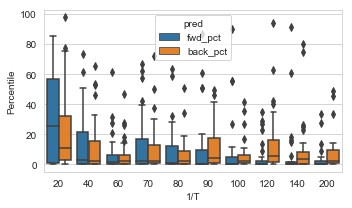

In [101]:
pp = PdfPages("../figures/fig4e.pdf")
plt.figure(figsize=[5,3])
sns.set_style("whitegrid")
df_long = pd.melt(df, "T", var_name="pred", value_name="pct")
df_long["T"] = [int(x) for x in df_long["T"]]
sns.boxplot(x="T", y="pct", hue="pred", data=df_long)
plt.xlabel("1/T")
plt.ylabel("Percentile")
plt.tight_layout()
pp.savefig()
pp.close()

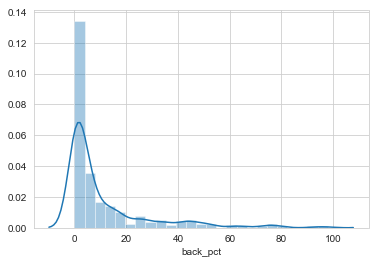

In [74]:
sns.distplot(df["back_pct"])

/Users/bdo/miniconda3/envs/myenv2/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


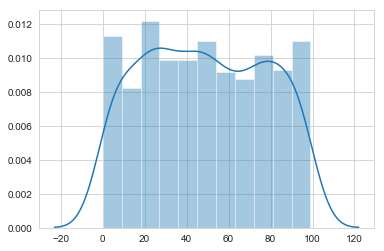

In [85]:
null_dist = [np.random.randint(0, 100) for i in range(1000)]
sns.distplot(null_dist)

In [102]:
stats.mannwhitneyu(df["fwd_pct"], null_dist)

MannwhitneyuResult(statistic=37189.0, pvalue=2.103933046988788e-87)

In [99]:
stats.mannwhitneyu(df["back_pct"], null_dist)

MannwhitneyuResult(statistic=36901.0, pvalue=7.909357437111842e-88)